In [2]:
"""
OBJETIVO : Realizar pruebas manuales con los mejores modelos escogidos, 
            de esta forma analizaar su comportamiento con conjunto de datos
            personalizados.
            
"""
Autor='Diego Paredes'

In [3]:
#Manejo de Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from skimage import io

#Machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Librerias estandar (Extras)
import re
import os
import time
import random
from datetime import datetime
import glob
from numpy import linalg as LA
import traceback

In [4]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [5]:
"""
VARIABLES GENERALES
"""

path_imagenes = 'F:/GOES/'      
GLOBAL_DS = None

products = ['C13','C07','C08']
times   = ['10','20','30','40','50','00']

In [6]:
def testALL(criterio, model):
    df = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/Reporte-BEST_{criterio}.csv')
    
    for i in df.index:
        params = {
        'idTest'    : df['idTest'][i],
        'epoca'     : df['epoca'][i],
        'ascending' : False,
        'dsTipo'    :'Validacion',
        'umbrales'  : [0.5,0.5],
        'model'     : model,
        'grafica'   : False
        }
        _, _ = getStats(path_base, params)       
        

In [7]:
def getMetrics( HP ):    
    redTipo = HP['redTipo']     
    lr = HP['lr']    
    
    if redTipo == 'Clasificacion':    
        optimizer = keras.optimizers.Adam(learning_rate=lr)   
        if HP['loss'] == 'binary_crossentropy':
            loss_fn= keras.losses.BinaryCrossentropy()
        
        train_acc_metric = keras.metrics.BinaryCrossentropy()
        val_acc_metric = keras.metrics.BinaryCrossentropy()
        
        
        metrics = ['acc', keras.metrics.TruePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.FalseNegatives()]
        

    elif redTipo == 'Regresion':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        loss_fn=keras.losses.MeanSquaredError()
        train_acc_metric = keras.metrics.MeanSquaredError()
        val_acc_metric = keras.metrics.MeanSquaredError()                                             
        metrics = ['mse']
        
        
    else:
        print('No se pudo crear las metricas')
        return -1    
         
        
    logs = Callback()
    callbacks = [logs]                     
  
        
    metrics = {'optimizer': optimizer, 'loss_fn':loss_fn,'train_acc_metric': train_acc_metric,
               'val_acc_metric': val_acc_metric, 'metrics': metrics,'callbacks': callbacks}
    
    return metrics
        

In [8]:
def get_sat_time_steps(n):    
    if n==2:
        return [5,0]
    if n==3:
        return [5,3,0]
    if n==4:
        return [5,3,2,0]
    if n==5:
        return [5,3,2,1,0]
    if n==6:
        return [5,4,3,2,1,0]
    
    return [5]

In [9]:
#Transformamos un filename tensor en una imagen
def read_png_file(item, value, p,run, path_base, products, times):
    # imagenData[0] = XO     # imagenData[1] = XA     # imagenData[2] = Fecha
    imagenData = tf.strings.split(item['imagen'], sep='--')
    size = int(p['margen'][run] / 2)

    timeJoin = []
    for j in get_sat_time_steps(p['tiempos'][run]):
        filename = path_base + 'PNG/' + imagenData[2] + '/' + imagenData[2] + '_' + str(j) + '.png'
        
        image_string = tf.io.read_file(filename)
    
        img_decoded = tf.io.decode_png(image_string, dtype=tf.uint16, channels=3)
        img_decoded = tf.cast(img_decoded, dtype=tf.float32) / tf.constant(65535, dtype=tf.float32)
        
                
        timeJoin.insert(0,img_decoded[int(imagenData[1]) - size:int(imagenData[1]) + size,
                                      int(imagenData[0]) - size:int(imagenData[0]) + size,
                                      0:p['canales'][run]])
 
        
    if p['tiempos'][run]==1:
        imagenData = tf.reshape(timeJoin[0],(p['margen'][run],p['margen'][run],p['canales'][run]))
    else:
        if p['meanMatrizImagen']:        
            img = tf.reduce_mean( timeJoin , axis=0 )
            imagenData = tf.reshape(img,(p['margen'][run],p['margen'][run],p['canales'][run]))
        else:
            img = tf.stack(timeJoin, axis=0)
            imagenData = tf.reshape(img,(p['tiempos'][run],p['margen'][run],p['margen'][run],p['canales'][run]))
        
    
    
    if len(p['inputs']) == 1:
        return imagenData, int(value)
    
    item['imagen'] = imagenData
    itemL = []
    for inpL in p['inputs']:
        itemL.append(item[inpL])
    
    return tuple(itemL), int(value)

In [10]:
def getModelFile(idModel, epoca):
    # Buscamos todos los modelos en el path_base
    os.chdir(f'{path_base}/Archivos/Resultados/')
    listFiles = list(glob.glob('**/**/**/*.hdf5'))       
    
    # Seleccionamos el id y epoca
    models = [x for x in listFiles if str(idModel) in x] 
    models = [x for x in models if f'Model_{epoca:02d}_' in x]
    
    if len(models)<1:
        print(f"ERROR: No se encontro el modelo {idModel} para la epoca {epoca}")
        return
    print(models[0])
    return models[0]

In [11]:
def evaluarModelo(path_base, dsPruebas,modelo, p_train):  
    global GLOBAL_DS
    inputsList = {}
    for inp in p_train['inputs']:
        inputsList[inp] = dsPruebas[inp].tolist()       

    dsP = tf.data.Dataset.from_tensor_slices(((inputsList),dsPruebas[p_train['outputs']].tolist()))
    dsP = dsP.map(lambda x ,y : read_png_file(x,y,p_train,0,path_imagenes,products,times))
    
    dsP = dsP.batch(p_train['batch'])#.prefetch(tf.data.AUTOTUNE)  
    GLOBAL_DS = dsP
    
    hist = modelo.predict(dsP, verbose=1)

    hist = pd.DataFrame({'valores': hist.flatten().tolist()})
    hist['dato'] = dsPruebas['dato']
    hist['clase'] = dsPruebas['clase']
    hist['XO'] = dsPruebas['XO']
    hist['XA'] = dsPruebas['XA']
    hist['fecha'] = dsPruebas['fecha']
    hist['lon'] = dsPruebas['longitud']
    hist['lat'] = dsPruebas['latitud']
    
    hist['codigo'] = dsPruebas['codigo']
    hist['90%'] = dsPruebas['90%']
    hist['99%'] = dsPruebas['99%']
    
    
    hist.to_csv(f'{path_base}/Archivos/Reportes/Pruebas/{p_train["epoca"]}_{p_train["idModel"]}_{p_train["dsTipo"]}.csv', index=False)
        
    return hist

In [12]:
def getHPModel(params, dfModels, varProject):    
    inputs = dfModels['P-inputs'].iloc[0]
    inp = inputs[1:-2].replace("'","").replace(' ','').split(',')
    HP = {         
            # Datos del modelo
          'redTipo'  : params['model'], 
          'inputs'   : inp,
          'meanMatrizImagen' : False, 
          'outputs'  : dfModels['P-outputs'].iloc[0], 
          'num_class': 2,

           # Hiper parametros 
          'canales'  : [int(dfModels['P-canales'].iloc[0])],
          'tiempos'  : [int(dfModels['P-tiempos'].iloc[0])],
          'margen'   : [int(dfModels['P-margen'].iloc[0])],
          'runs'     : 1,

          # Entrenamiento
          'batch'    : 32,
          'DA'       : True,    
          'idModel'  : dfModels['idTest'].iloc[0],
          'epoca'    : dfModels['epoca'].iloc[0],
          'dsTipo'   : params['dsTipo'],
          'lr'       : dfModels['P-lr'].iloc[0],
          'loss'     :dfModels['P-loss'].iloc[0]
     }
    
    return HP

In [13]:
def testModels(path_base, params, dfModels=pd.DataFrame(), dfPruebas=pd.DataFrame(), HP={}): 
    """ CARGAMOS EL MODELO """       
    # Buscamos el nombre del modelo 
    modelFile = getModelFile(HP['idModel'], HP['epoca'])
    print(modelFile)
    _modelo = tf.keras.models.load_model(modelFile)      
    
    print(f"Se usará inputs: {HP['inputs']} y output: {HP['outputs']}")    
    metricas = getMetrics(HP)    
    _modelo.compile(optimizer=metricas['optimizer'],loss=metricas['loss_fn'],metrics=metricas['metrics'],)        


    """ RESULTADOS """   
    resultado = evaluarModelo(path_base, dfPruebas,_modelo, HP)
        
    return resultado

In [14]:
# Buscamos el DS validacion
def getDataset(path_base,params, idProject): 
    """ BUSCAMOS EL ARCHIVO DE PROYECTOS """
    if not idProject:
        print(f'ERROR: ID PROJECT no puede ser vacio / nulo: {idProject}')
        return 
    dfP = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{params["model"]}/Proyectos.csv')
    dfP = dfP[dfP['idProject'] == idProject]
    if dfP.empty:
        print(f'ERROR: No se encontro informacion del project: {idProject}')   
        return 
    
    """ BUSCAMOS LOS DATOS DE PRUEBA """
    dsName = dfP['dsVal'].iloc[0]
    dsName = dsName.replace('Validacion',params['dsTipo'])
    print('Dataset a utilizar',dsName)
    dfPruebas = pd.read_csv(dsName)

    return dfPruebas, dfP

In [15]:
def getBestModel(path_base, p):
    # Leemos las estadisticas
    dfA = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{p["model"]}/Reporte-TOTAL.csv')
    dfA = dfA[(dfA['idTest']==p["idTest"]) & (dfA['epoca']==p["epoca"])]
    
    dfA = dfA.head(1)
    return dfA , dfA['idProject'].iloc[0]

In [16]:
#Umbrales = [C02,M02]
def getStats(path_base, params):
    if params['umbrales'][0] < params['umbrales'][0]:
        print('ERROR : El umbral de C02 no puede ser menor que el de M02')
        return
    
    print('-----------------------------------------------')
    print(f'\n ESTADISTICAS PARA PROYECTO {params["idTest"]}')
    #print(f'Criterio para mejor estadisticas  : {params["criterio"]}')
    print(f'Dataset usado para estadisticas   : {params["dsTipo"]}')
    print(f'Umbrales C02 - : {params["umbrales"][0]} - M02: {params["umbrales"][1]}')
    print('-----------------------------------------------')
    
    """ VERFICAMOS SI EXISTE LOS RESULTADOS """
    
    print(F"No se encontro resultados en reportes ...procediendo a generar resultados")
        
    
    """ BUSCAMOS EL MODELO A USAR """
    dfModels, idProject = getBestModel(path_base, params)


    """ BUSCAMOS EL DS A USAR """
    dfPruebas, varProject = getDataset(path_base,params, idProject)
    
    """ DEFINIMOS VARIALBES EXTRAS """
    _HP = getHPModel(params, dfModels, varProject)
    print(_HP)
    # Buscamos si se existe la evaluacion
    if not params['hard_reset']:
        try:        
            listResult = pd.read_csv(f'{path_base}/Archivos/Reportes/Pruebas/{params["epoca"]}_{params["idTest"]}_{params["dsTipo"]}.csv')         
        except:
            """ REALIZAMOS Y/O GUARDAMOS LAS PRUEBAS """    
            listResult = testModels(path_base, params, dfModels = dfModels, dfPruebas=dfPruebas, HP=_HP) 
    else:
        listResult = testModels(path_base, params, dfModels = dfModels, dfPruebas=dfPruebas, HP=_HP)
    
    
    """ REALIZAMOS LOS GRAFICOS """    
    if params['grafica']:
        df, mc, dfMC = graficarResults(path_base,params, listResult, _HP)
    
    return df, mc, dfMC, _HP

In [17]:
def getClasePred(df,umb):       
    df = df.sort_values('valores')
    clas = []
    stats = []    
    for iDF in df.index:        
        pred = df['valores'][iDF]
        real = df['clase'][iDF]        
        
        if  (pred >= umb[0]):
            _T = 1
            tipo = 'tp' if real else 'fp'
        elif  (1-pred >= umb[1]):
            _T = 0
            tipo = 'fn' if real else 'tn'
        else:
            _T = 2        
            tipo = 'dC' if real else 'dM'
        
        clas.append(_T)
        stats.append(tipo)
    
    df['pred'] = clas
    df['tipo'] = stats
    return df

In [18]:
def getMC_DF(result):
    result = result.sort_values('valores', ascending=True)

    MC = {
        'tp' : [len(result[(result['clase']==1)])],'tn' : [0],'fn' : [0],'fp' : [len(result[(result['clase']==0)])],'umb': [0]
        }

    for i in result.index:  
        MC['umb'].append(result['valores'][i])
        if result['clase'][i]: # Aumenta una pred de M02 que es C02  (+FN)
            MC['fn'].append(MC['fn'][-1]+1)
            MC['tn'].append(MC['tn'][-1])

            MC['tp'].append(MC['tp'][-1]-1)                
            MC['fp'].append(MC['fp'][-1])           

        else:                  # Aumenta una pred de M02 que es M02  (+TN)
            MC['tn'].append(MC['tn'][-1]+1)        
            MC['fn'].append(MC['fn'][-1])

            MC['tp'].append(MC['tp'][-1])        
            MC['fp'].append(MC['fp'][-1]-1)       



    dfMC = pd.DataFrame(MC)
    dfMC['tnr'] = dfMC['tn'] / (dfMC['tn'] + dfMC['fp'])
    dfMC['tpr'] = dfMC['tp'] / (dfMC['tp'] + dfMC['fn'])
    dfMC['fpr'] = dfMC['fp'] / (dfMC['fp'] + dfMC['tn'])
    
    dfMC['%Total'] = (dfMC['tp'] + dfMC['fp']) / (len(result)) *100
    dfMC['%Error Rate'] = ( dfMC['fp']) / (dfMC['tp'] + dfMC['fp']) *100
        
    return dfMC

In [19]:
def getNIV_DF(result, asc, xAxis = 'dato'):
    df = result[result['pred']!=2]
    niveles = df.sort_values(xAxis, ascending=asc)[xAxis].unique()
    dT = {
        'niv' : [],'tp'  : [],'tn'  : [],'fp'  : [],'fn'  : []
    }
    for niv in niveles:      
        if asc:
            _df = df[df['dato']>=niv]
        else:
            _df = df[df['dato']<=niv]
        try:
            (tn, fp, fn, tp) = confusion_matrix(_df['clase'], _df['pred'], labels=[True, False]).ravel()
            dT['niv'].append(niv)
            dT['tn'].append(tn)
            dT['fp'].append(fp)
            dT['fn'].append(fn)
            dT['tp'].append(tp)
        except:
            pass

    dfNIV = pd.DataFrame(dT)
    dfNIV['tnr'] = dfNIV['tn'] / (dfNIV['tn'] + dfNIV['fp'])
    dfNIV['tpr'] = dfNIV['tp'] / (dfNIV['tp'] + dfNIV['fn'])
    dfNIV['C02'] = dfNIV['tp'] + dfNIV['fn']
    dfNIV['M02'] = dfNIV['tn'] + dfNIV['fp']    
    return dfNIV

In [20]:
a = np.array([0,1,2])
print(type(a))
if type(a) == np.ndarray:
    print('asd')


<class 'numpy.ndarray'>
asd


In [21]:
def sateliteImg(path_imagenes,fecha='2020-02-02-13', canales=['C07'], point = [600,475], margen=50):
    data = []
    for j in range(6):
        fileDir = path_imagenes + 'PNG/' + fecha + '/' + fecha + '_' + str(j) + '.png'
        _t = io.imread(fileDir)
        data.append(np.array([_t[:,:,0],_t[:,:,1],_t[:,:,2]], dtype=np.float32))       
    
    data = np.array(data)
    print(data.shape)
    fig = px.imshow(data, animation_frame=0, facet_col=1, binary_string=True, labels={'facet_col':'CANAL'})    
    fig.update_layout(title = 'Imagenes satelitales (C13 - C07 - C08)', height=600)   
    
    
    x0 = int(point[0] - margen/2)
    x1 = int(point[0] + margen/2)
    y0 = int(point[1] - margen/2)
    y1 = int(point[1] + margen/2)
    fig.add_trace(go.Scatter(x=[x0],y=[y0], mode='markers', marker=dict(size=2,color=f'rgba(255,0,0,0.9)')))
    fig.add_trace(go.Scatter(x=[x0],y=[y1], mode='markers', marker=dict(size=2,color=f'rgba(255,0,0,0.9)')))
    fig.add_trace(go.Scatter(x=[x1],y=[y1], mode='markers', marker=dict(size=2,color=f'rgba(255,0,0,0.9)')))
    fig.add_trace(go.Scatter(x=[x1],y=[y0], mode='markers', marker=dict(size=2,color=f'rgba(255,0,0,0.9)')))
    fig.show()
    return data

In [22]:
def scatterPrediccion(result, p, HP, xAxis='dato'):
    print(HP)
    r0 = result[result['clase']==1]
    r1 = result[result['clase']==0]
    #print(r1[:5])

    fig = go.FigureWidget(  data = [go.Scatter(x=r0[xAxis], y=r0["valores"], name='Class 1 (C02)', hovertext=r0["codigo"],
                                    mode = 'markers',marker= dict(color='rgba(255,0,0,1)')),
                                    go.Scatter(x=r1[xAxis], y=r1["valores"], name='Class 0 (W02)', hovertext=r1["codigo"],
                                    mode = 'markers',marker= dict(color='rgba(0,0,255,1)'))
                                   ] 
                         )
    fig.layout = {  'shapes': [
                            {'type': 'line','x0': 0,'y0': p['umbrales'][0],'x1': 300,'y1': p['umbrales'][0],'line': {'color': 'rgb(165,42,42)','width': 1}},
                            {'type': 'line','x0': 0,'y0': p['umbrales'][1],'x1': 300,'y1': p['umbrales'][1],'line': {'color': 'rgb(50, 171, 96)','width': 1}}
                            ],
                    'title' : 'Scatter (Precipitation VS Prediction)',
                    'xaxis' : {'title' : f'Precipitation {xAxis}'},
                    'yaxis' : {'title' : 'Prediction'}
                 }
                              
    fig.update_layout(legend=dict(
        orientation="h",       
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    sldC02 = widgets.FloatSlider(max = 1, min=0, description = 'C02 - Alpha', value=1)
    sldM02 = widgets.FloatSlider(max = 1, min=0, description = 'M02 - Alpha', value=1)
    
    scatter_C02 = fig.data[0]
    scatter_M02 = fig.data[1]
    
    def update_point_C02(trace, points, selector):
        if points.point_inds:
            indc = list(r0.index)[points.point_inds[0]] 
            print('Indice: ',indc)
            print(f'{indc} - {result.loc[indc,:]}')
            _ = sateliteImg(path_imagenes,fecha=result['fecha'][indc], point = [result['XO'][indc],result['XA'][indc]], margen=HP['margen'][0])
    
    def update_point_M02(trace, points, selector):
        if points.point_inds: 
            indm = list(r1.index)[points.point_inds[0]]  
            print('Indice: ',indm)
            print(f'{indm} - {result.loc[indm,:]}')
            _ = sateliteImg(path_imagenes,fecha=result['fecha'][indm], point = [result['XO'][indm],result['XA'][indm]], margen=HP['margen'][0])
            
    scatter_C02.on_click(update_point_C02)
    scatter_M02.on_click(update_point_M02)

    # Update color callback
    def update_C02(trace):    
        fig.data[0].marker =  dict(color=f'rgba(255,0,0,{trace["new"]})')

    def update_M02(trace):    
        fig.data[1].marker =  dict(color=f'rgba(0,0,255,{trace["new"]})')

    sldC02.observe(update_C02, 'value')
    sldM02.observe(update_M02, 'value')

    widgets.VBox([ sldC02,sldM02, fig])
    display(widgets.VBox([ sldC02,sldM02, fig]))
    

In [23]:
def graficarResults(path_base,p, df, margen):
    #df = df[df['fecha'].str[:4] == '2021']
    """ GRAFICA DE DISPERSION DE PREDICCIONES """
    print(' GRAFICAR ')
    dfGrafica = getClasePred(df,p['umbrales']) 
    if 'dispersion' in p['grafica']:
        scatterPrediccion(dfGrafica, p, margen)
    
    """ MATRIX DE CONFUSION """ 
    res = dfGrafica['tipo'].value_counts()
    dT = {'fn': 0 ,'tn': 0 , 'tp': 0 , 'fp': 0 , 'dC' :0, 'dM': 0}
    for k in res.keys():
        dT[k] = res[k]
    mc = {'REAL C02' : [dT['tp'],dT['dC'],dT['fn']], 'REAL M02': [dT['fp'],dT['dM'],dT['tn']]}
    mc = pd.DataFrame(mc, index = ['PRED C02','DUD','PRED M02'])
           
    """ ROC CON RECALL """
    dfMC = getMC_DF(dfGrafica)
    _umb = []
    for i in dfMC.index:
        if not int(i)%300:
            _umb.append(f"U: {round(dfMC.iloc[i]['umb'],2)}")
        else:
            _umb.append('')
            
    dfMC['umb2'] = _umb
    
    if 'sensibilidad1' in p['grafica']:
        #fig = px.line(dfMC, x="fpr", y="tpr", text='umb2')
        fig = px.line(dfMC, x="%Error Rate", y="%Total", text='umb')
        fig.layout = {
                #'shapes': [{'type': 'line','x0': 0,'y0': 0,'x1': 1,'y1': 1,'line': {'color': 'rgb(50, 171, 96)','width': 1}}],
                'height': 600,
                'width' : 800,
                'title' : 'SENSIBILIDAD DE TNR vs TPR',
                'xaxis' : {'title' : '% Error Rate'},
                'yaxis' : {'title' : '% Total'},
                'font'  : {'size' :20}
                }
        fig.update_traces(mode='lines+text',textposition='top right')
        fig.show()
    
    """ SENSIBILIDAD EN RANGO PRECIPITACIONES """
    dfNIV = getNIV_DF(dfGrafica, True)
    
    if 'sensibilidad2' in p['grafica']:
        fig = go.Figure()    
        fig.add_trace( go.Scatter(mode='lines',x=dfNIV["niv"], y=dfNIV["tpr"], text=dfNIV['C02'], name='TPR')) 
        fig.add_trace( go.Scatter(mode='lines',x=dfNIV["niv"], y=dfNIV["tnr"], text=dfNIV['M02'], name='TNR')) 
        fig.update_layout(title={'text':'GRAFICA DE SENSIBILIDAD DE PRECIPITACION (TNR Y TPR) |->'}, xaxis={'title': 'UMBRALES'},
                      yaxis={'title': 'PORC. ACIERTOS'}, yaxis_range=[0,1])
        fig.show()
    
        dfNIV = getNIV_DF(dfGrafica, False)
    
        fig = go.Figure()    
        fig.add_trace( go.Scatter(mode='lines',x=dfNIV["niv"], y=dfNIV["tpr"], text=dfNIV['C02'], name='TPR')) 
        fig.add_trace( go.Scatter(mode='lines',x=dfNIV["niv"], y=dfNIV["tnr"], text=dfNIV['M02'], name='TNR')) 
        fig.update_layout(title={'text':'GRAFICA DE SENSIBILIDAD DE PRECIPITACION (TNR Y TPR) <-|'}, xaxis={'title': 'UMBRALES'},
                      yaxis={'title': 'PORC. ACIERTOS'}, yaxis_range=[0,1])
    
    
        fig.show()
    
    return dfGrafica, mc, dfMC

-----------------------------------------------

 ESTADISTICAS PARA PROYECTO 20240326_224209
Dataset usado para estadisticas   : Validacion
Umbrales C02 - : 0.5 - M02: 0.5
-----------------------------------------------
No se encontro resultados en reportes ...procediendo a generar resultados
Dataset a utilizar C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/Validacion/ClaseV7_ValidacionDS.csv
{'redTipo': 'Clasificacion', 'inputs': ['imagen', 'dato', 'umb1', 'altura'], 'meanMatrizImagen': False, 'outputs': 'clase', 'num_class': 2, 'canales': [3], 'tiempos': [6], 'margen': [8], 'runs': 1, 'batch': 32, 'DA': True, 'idModel': '20240326_224209', 'epoca': 249, 'dsTipo': 'Validacion', 'lr': 0.001, 'loss': 'binary_crossentropy'}
 GRAFICAR 
{'redTipo': 'Clasificacion', 'inputs': ['imagen', 'dato', 'umb1', 'altura'], 'meanMatrizImagen': False, 'outputs': 'clase', 'num_class': 2, 'canales': [3], 'tiempos': [6], 'margen': [8], 'runs': 1, 'ba

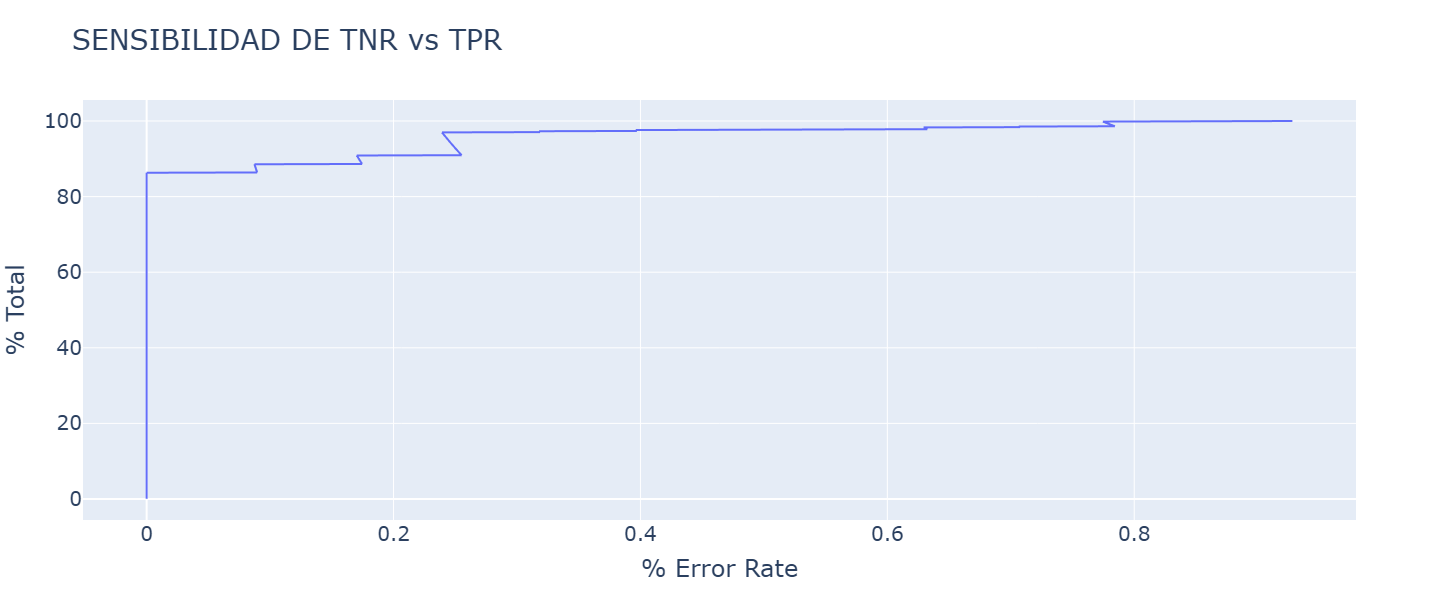


      MATRIZ DE CONFUSION 
TPR: 0.846
TNR: 1.000


REAL C02  REAL M02
PRED C02      1084         0
DUD              0         0
PRED M02       197        12

In [24]:
params = {
    'idTest'    : '20240326_224209',#'20240326_224209' '20240326_050743' '20220618_023232', # '20221217_130543'
    'epoca'     : 249,# 20230710_224918 60
    'ascending' : False,
    'dsTipo'    :'Validacion',
    'umbrales'  : [0.5,0.5],
    'model'     :'Clasificacion',
    'grafica'   : ['dispersion','mc','sensibilidad1'] , #['mc','dispersion','sensibilidad1','sensibilidad2'], #'dispersion','sensibilidad1','sensibilidad2'
    'hard_reset' : False,
}
result,mc, dfMC, HP = getStats(path_base, params) 
print('\n      MATRIZ DE CONFUSION ')
print(f"TPR: {mc['REAL C02']['PRED C02'] / mc['REAL C02'].sum():.3f}")
print(f"TNR: {mc['REAL M02']['PRED M02'] / mc['REAL M02'].sum():.3f}")
mc

In [25]:
(0.887 + 0.750)/2

0.8185

-----------------------------------------------

 ESTADISTICAS PARA PROYECTO 20240326_224209
Dataset usado para estadisticas   : Validacion
Umbrales C02 - : 0.5 - M02: 0.5
-----------------------------------------------
No se encontro resultados en reportes ...procediendo a generar resultados
Dataset a utilizar C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/Validacion/ClaseV7_ValidacionDS.csv
{'redTipo': 'Clasificacion', 'inputs': ['imagen', 'dato', 'umb1', 'altura'], 'meanMatrizImagen': False, 'outputs': 'clase', 'num_class': 2, 'canales': [3], 'tiempos': [6], 'margen': [8], 'runs': 1, 'batch': 32, 'DA': True, 'idModel': '20240326_224209', 'epoca': 245, 'dsTipo': 'Validacion', 'lr': 0.001, 'loss': 'binary_crossentropy'}
 GRAFICAR 
{'redTipo': 'Clasificacion', 'inputs': ['imagen', 'dato', 'umb1', 'altura'], 'meanMatrizImagen': False, 'outputs': 'clase', 'num_class': 2, 'canales': [3], 'tiempos': [6], 'margen': [8], 'runs': 1, 'ba

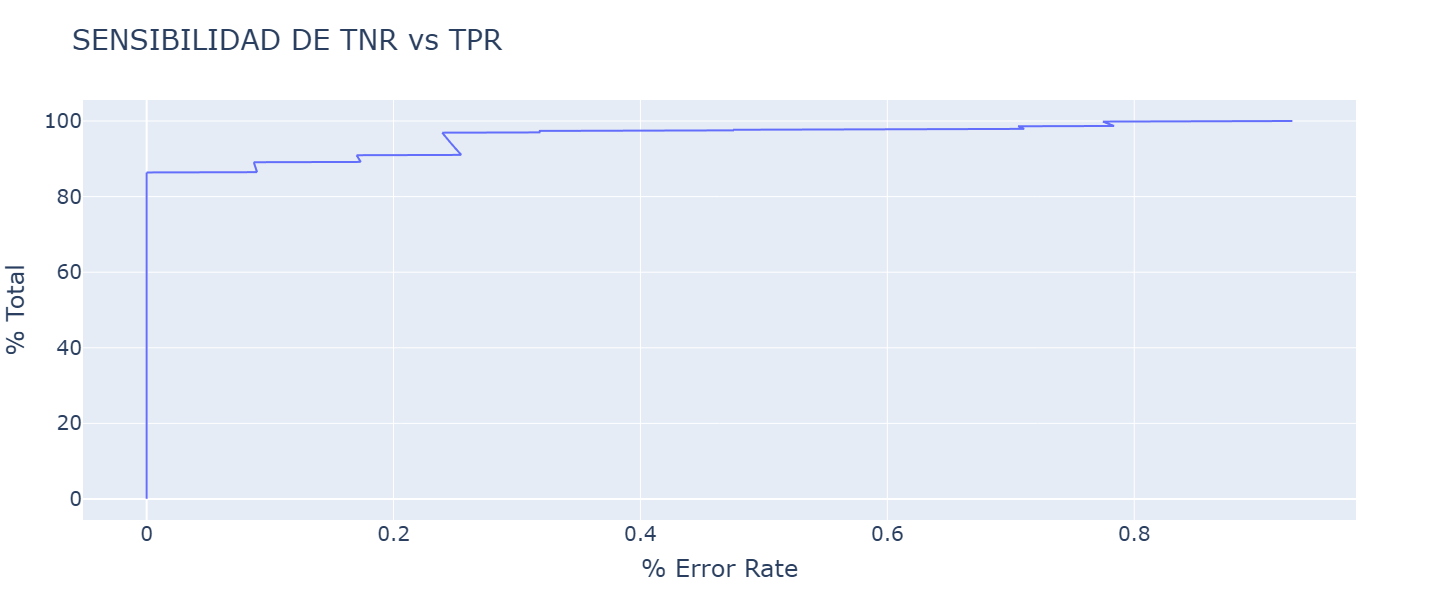


      MATRIZ DE CONFUSION 
TPR: 0.842
TNR: 1.000


REAL C02  REAL M02
PRED C02      1079         0
DUD              0         0
PRED M02       202        12

In [26]:
params = {
    'idTest'    : '20240326_224209',#'20240326_224209' '20240326_050743' '20220618_023232', # '20221217_130543'
    'epoca'     : 245,#  60
    'ascending' : False,
    'dsTipo'    :'Validacion',
    'umbrales'  : [0.5,0.5],
    'model'     :'Clasificacion',
    'grafica'   : ['dispersion','mc','sensibilidad1'] , #['mc','dispersion','sensibilidad1','sensibilidad2'], #'dispersion','sensibilidad1','sensibilidad2'
    'hard_reset' : False,
}
result,mc, dfMC, HP = getStats(path_base, params) 
print('\n      MATRIZ DE CONFUSION ')
print(f"TPR: {mc['REAL C02']['PRED C02'] / mc['REAL C02'].sum():.3f}")
print(f"TNR: {mc['REAL M02']['PRED M02'] / mc['REAL M02'].sum():.3f}")
mc

In [27]:
params = {
    'idTest'    : '20230710_224918',#'20240326_224209' '20240326_050743' '20220618_023232', # '20221217_130543'
    'epoca'     : 58,# 20230710_224918 60
    'ascending' : False,
    'dsTipo'    :'Validacion',
    'umbrales'  : [0.5,0.5],
    'model'     :'Clasificacion',
    'grafica'   : ['dispersion','mc','sensibilidad1'] , #['mc','dispersion','sensibilidad1','sensibilidad2'], #'dispersion','sensibilidad1','sensibilidad2'
    'hard_reset' : False,
}
#result,mc, dfMC, HP = getStats(path_base, params) 
print('\n      MATRIZ DE CONFUSION ')
print(f"TPR: {mc['REAL C02']['PRED C02'] / mc['REAL C02'].sum():.3f}")
print(f"TNR: {mc['REAL M02']['PRED M02'] / mc['REAL M02'].sum():.3f}")
mc


      MATRIZ DE CONFUSION 
TPR: 0.842
TNR: 1.000


REAL C02  REAL M02
PRED C02      1079         0
DUD              0         0
PRED M02       202        12

In [28]:
params = {
    'idTest'    : '20230706_184408',#'20240326_224209' '20240326_050743' '20220618_023232', # '20221217_130543'
    'epoca'     : 39,# 20230710_224918 60
    'ascending' : False,
    'dsTipo'    :'Validacion',
    'umbrales'  : [0.5,0.5],
    'model'     :'Clasificacion',
    'grafica'   : ['dispersion','mc','sensibilidad1'] , #['mc','dispersion','sensibilidad1','sensibilidad2'], #'dispersion','sensibilidad1','sensibilidad2'
    'hard_reset' : False,
}
#result,mc, dfMC, HP = getStats(path_base, params) 
print('\n      MATRIZ DE CONFUSION ')
print(f"TPR: {mc['REAL C02']['PRED C02'] / mc['REAL C02'].sum():.3f}")
print(f"TNR: {mc['REAL M02']['PRED M02'] / mc['REAL M02'].sum():.3f}")
mc


      MATRIZ DE CONFUSION 
TPR: 0.842
TNR: 1.000


REAL C02  REAL M02
PRED C02      1079         0
DUD              0         0
PRED M02       202        12

In [29]:
params = {
    'idTest'    : '20240326_224209',#'20240326_224209' '20240326_050743' '20220618_023232', # '20221217_130543'
    'epoca'     : 246,# 20230710_224918 60
    'ascending' : False,
    'dsTipo'    :'Pruebas',
    'umbrales'  : [0.5,0.5],
    'model'     :'Clasificacion',
    'grafica'   : ['dispersion','mc','sensibilidad1'] , #['mc','dispersion','sensibilidad1','sensibilidad2'], #'dispersion','sensibilidad1','sensibilidad2'
    'hard_reset' : False,
}
#result,mc, dfMC, HP = getStats(path_base, params) 
print('\n      MATRIZ DE CONFUSION ')
print(f"TPR: {mc['REAL C02']['PRED C02'] / mc['REAL C02'].sum():.3f}")
print(f"TNR: {mc['REAL M02']['PRED M02'] / mc['REAL M02'].sum():.3f}")
mc


      MATRIZ DE CONFUSION 
TPR: 0.842
TNR: 1.000


REAL C02  REAL M02
PRED C02      1079         0
DUD              0         0
PRED M02       202        12

-----------------------------------------------

 ESTADISTICAS PARA PROYECTO 20230709_112005
Dataset usado para estadisticas   : Pruebas
Umbrales C02 - : 0.5 - M02: 0.5
-----------------------------------------------
No se encontro resultados en reportes ...procediendo a generar resultados
Dataset a utilizar C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/Pruebas/ClaseV7_PruebasDS.csv
{'redTipo': 'Clasificacion', 'inputs': ['imagen', 'dato', 'umb1', 'altura'], 'meanMatrizImagen': False, 'outputs': 'clase', 'num_class': 2, 'canales': [3], 'tiempos': [3], 'margen': [10], 'runs': 1, 'batch': 32, 'DA': True, 'idModel': '20230709_112005', 'epoca': 99, 'dsTipo': 'Pruebas', 'lr': 0.001, 'loss': 'binary_crossentropy'}
 GRAFICAR 
{'redTipo': 'Clasificacion', 'inputs': ['imagen', 'dato', 'umb1', 'altura'], 'meanMatrizImagen': False, 'outputs': 'clase', 'num_class': 2, 'canales': [3], 'tiempos': [3], 'margen': [10], 'runs': 1, 'batch': 32, '

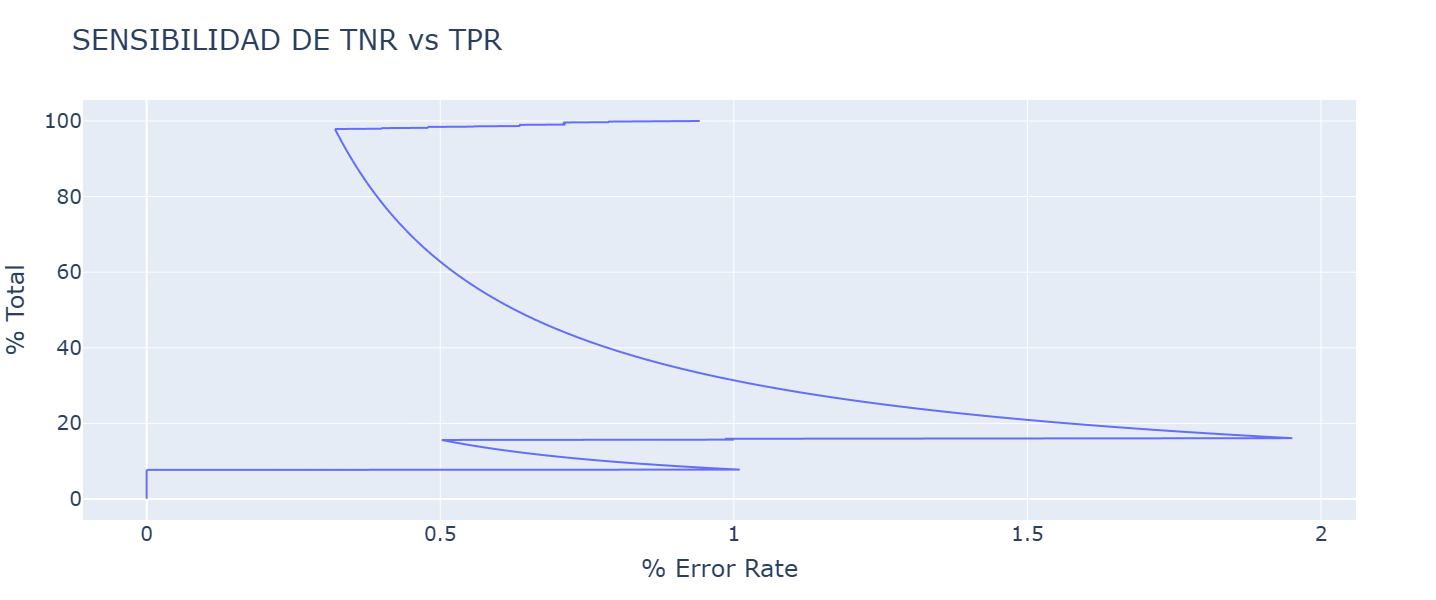


      MATRIZ DE CONFUSION 
TPR: 0.959
TNR: 0.667


REAL C02  REAL M02
PRED C02      1210         4
DUD              0         0
PRED M02        52         8

In [51]:
params = {
    'idTest'    : '20230709_112005',#'20240326_224209' '20240326_050743' '20220618_023232', # '20221217_130543'
    'epoca'     : 99,# 20230710_224918 60
    'ascending' : False,
    'dsTipo'    :'Pruebas',
    'umbrales'  : [0.5,0.5],
    'model'     :'Clasificacion',
    'grafica'   : ['dispersion','mc','sensibilidad1'] , #['mc','dispersion','sensibilidad1','sensibilidad2'], #'dispersion','sensibilidad1','sensibilidad2'
    'hard_reset' : False,
}
result,mc, dfMC, HP = getStats(path_base, params) 
print('\n      MATRIZ DE CONFUSION ')
print(f"TPR: {mc['REAL C02']['PRED C02'] / mc['REAL C02'].sum():.3f}")
print(f"TNR: {mc['REAL M02']['PRED M02'] / mc['REAL M02'].sum():.3f}")
mc

In [31]:
raise Exception('asd')

Exception: asd

In [52]:
result.head()

valores   dato  clase   XO   XA          fecha       lon      lat  \
455   0.000001  310.8      0  263  431  2021-05-25-19 -78.81339 -6.37914   
456   0.000002  305.5      0  263  431  2021-09-01-03 -78.81339 -6.37914   
1150  0.001053    8.2      1  178  351  2021-12-19-12 -80.34703 -4.93848   
169   0.004586   31.2      1  548  215  2021-04-23-08 -73.67925 -2.48757   
1224  0.007394   28.3      0  199  365  2021-03-07-16 -79.97107 -5.19465   

        codigo  90%    99%  pred tipo  
455   4726A602  0.2  6.775     0   tn  
456   4726A602  0.2  6.775     0   tn  
1150  47E0522C  0.0  0.100     0   fn  
169   47271776  0.3  9.936     0   fn  
1224  472F7636  0.0  0.100     0   tn

In [53]:
"""
    Datos de estaciones
"""

stat_path = f'{path_base}/Archivos/Inicial/estaciones.csv'
dfSt = pd.read_csv(stat_path)
dfSt.columns = ['-','CODIGO','ESTACION','LON','LAT','ALT']
#dfSt = dfSt.set_index('CODIGO')

In [54]:
df = result.groupby(['codigo', 'tipo']).count()[['valores']].reset_index()
df['CODIGO'] = 'X' + df['codigo'] 
#df = df.set_index('CODIGO')

In [55]:
df2 = df.merge(dfSt, on='CODIGO', how='left')
df2.head()

codigo tipo  valores   CODIGO    -         ESTACION       LON       LAT  \
0  107131   tp       17  X107131  276       LA FORTUNA -78.40242  -7.67042   
1  109091   tp       20  X109091  307       SAUCEPAMPA -77.75173  -9.04586   
2  109093   fn        1  X109093  295  PUERTO BERMUDEZ -74.94356 -10.28619   
3  109093   tp       12  X109093  295  PUERTO BERMUDEZ -74.94356 -10.28619   
4  110137   tp       16  X110137  322    12 DE OCTUBRE -76.52927 -10.60641   

      ALT  
0  3343.0  
1  2958.0  
2   267.0  
3   267.0  
4  3867.0

In [62]:
data_mapa = {}
df_final = result

def div_zero(a,b):
    if b==0:
        return 0
    else:
        return a/b
for codigo in df_final['codigo'].unique():
    data_mapa[codigo] = {
        'TNR' : div_zero(len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='tn')]) , (len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='tn')])+len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='fp')]))), # Recall de la clase 0 (M02)
        'TPR' : div_zero(len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='tp')]) , (len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='tp')])+len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='fn')]))),  # Recall de la clase 1 (C02)_
        'Success Ratio' : (len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='tp')]) + len(df_final[(df_final['codigo']==codigo)&(df_final['tipo']=='tn')])) / len(df_final[(df_final['codigo']==codigo)]),        
    }
    
    data_mapa[codigo]['acc_bal'] = (data_mapa[codigo]['TNR']  + data_mapa[codigo]['TPR']) / 2
data_mapa = pd.DataFrame(data_mapa).T.reset_index()
data_mapa['CODIGO'] = 'X' + data_mapa['index']
#data_mapa = data_mapa.set_index('CODIGO')
data_mapa = data_mapa.merge(dfSt, on='CODIGO', how='left')

df2 = data_mapa

In [57]:
#data_mapa['ACIERTOS'].hist() , data_mapa['ACIERTOS'].max()

In [58]:
data_mapa

index  TNR  TPR  Success Ratio  acc_bal     CODIGO    -  \
0   4726A602  1.0  1.0           1.00      1.0  X4726A602   70   
1   47E0522C  0.0  0.0           0.00      0.0  X47E0522C   37   
2   47271776  1.0  0.0           0.25      0.5  X47271776  183   
3   472F7636  1.0  0.0           1.00      0.5  X472F7636   26   
4   47252718  0.0  0.0           0.00      0.0  X47252718  180   
..       ...  ...  ...            ...      ...        ...  ...   
95    220907  0.0  1.0           1.00      0.5    X220907   47   
96  472AC278  0.0  1.0           1.00      0.5  X472AC278  126   
97  47E9177A  0.0  1.0           1.00      0.5  X47E9177A   13   
98  47E87066  0.0  1.0           1.00      0.5  X47E87066  193   
99  47E0D438  0.0  1.0           1.00      0.5  X47E0D438    0   

            ESTACION       LON       LAT     ALT  
0       CUTERVO GORE -78.81339  -6.37914  2616.0  
1       TAMBO GRANDE -80.34703  -4.93848    60.0  
2     SANTA CLOTILDE -73.67925  -2.48757   150.0  
3           MORROPON -79.97107  -5.19465   128.0  
4         ENAPU PERU -73.23694  -3.72722   126.0  
..               ...       ...       ...     ...  
95         NARANJITO -78.27598  -5.81968   500.0  
96      VON HUMBOLDT -76.93931 -12.08221   247.0  
97    EL CIRUELO ANA -80.16704  -4.29905   243.0  
98  PUERTO ESPERANZA -70.75028  -9.75028   275.0  
99            ALAMOR -80.39788  -4.48047   116.0  

[100 rows x 11 columns]

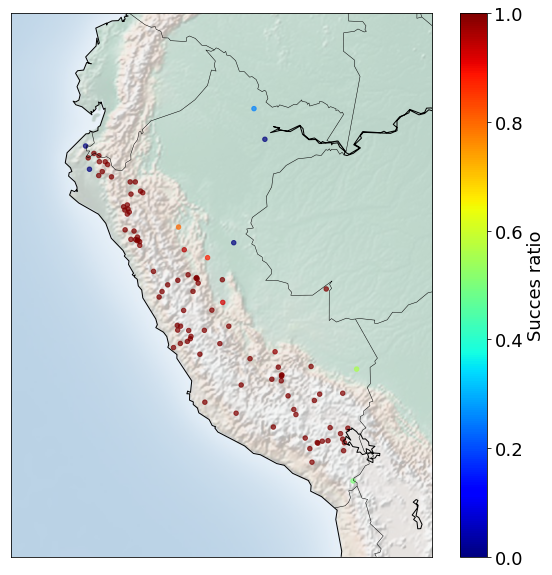

In [68]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Crear figura con tamaño personalizado
plt.figure(figsize=(10, 10))

# Crear el mapa del Perú
mapa = Basemap(llcrnrlon=-83.54, llcrnrlat=-20.22, urcrnrlon=-66.45, urcrnrlat=1.38, resolution='l', projection='merc')

# Dibujar la costa
mapa.drawcoastlines()

# Dibujar los límites de los países
mapa.drawcountries()

# Asignar colores a los puntos en función de una columna del DataFrame
colores = plt.cm.jet(df2['Success Ratio'].values)  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

# Dibujar puntos en el mapa con tamaño reducido y colores asignados
mapa.scatter(df2['LON'], df2['LAT'], s=20, c=colores, marker='o', alpha=0.7, label='Puntos', latlon=True)

# Ajustar el tamaño del mapa
#plt.xlim(-90, -60)
#plt.ylim(-25, 5)

# Añadir sombreado de relieve
mapa.shadedrelief(alpha=0.5)  # Puedes ajustar el valor de alpha según lo que necesites

# Crear un objeto ScalarMappable para la leyenda del color
sm = ScalarMappable(cmap=plt.cm.jet)
sm.set_array(df2['Success Ratio'])  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

# Añadir la leyenda del color
cbar = plt.colorbar(sm)
cbar.set_label('Succes ratio')
cbar.ax.tick_params(labelsize=18) 
cbar.ax.yaxis.label.set_size(18)
# Mostrar el mapa
plt.show()


In [ ]:
"""
Graficamos
"""
grafico_params = {
    'lat' : 'LAT',
    'lon' : 'LON',
    'hover_data' : ['CODIGO'],
    'zoom' : 5,
    'height' : 800,
    'color' : 'Success Ratio',
}
fig = px.scatter_mapbox(data_mapa,color_continuous_scale ='Blackbody', size_max=10, size=[1] * len(data_mapa),
                **grafico_params)
fig.update_layout(mapbox_style="open-street-map",
                     legend=dict( yanchor="top", y=0.2, xanchor="left", x=0.1),
                     showlegend=True)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
raise Exception ('asd')
si se logro mapera y peude que haga error en los negros?

In [ ]:
file_stations = f'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/SistemaQC/stations_data.csv'
df_stations = pd.read_csv(file_stations)
df_stations['Codigo'] = df_stations['Codigo'].astype(str)
df_stations.set_index('Codigo', inplace=True)
result['umbral1'] = result['codigo'].apply(lambda x:  df_stations.loc[x]['Umbral1'])

In [ ]:
len(df_stations[df_stations['Umbral1']>8])

In [ ]:
dfNIVResult = getNIV_DF(result, True, xAxis='umbral1')

fig = go.Figure()    
fig.add_trace( go.Scatter(mode='lines',x=dfNIVResult["niv"], y=dfNIVResult["tpr"], text=dfNIVResult['C02'], name='TPR')) 
fig.add_trace( go.Scatter(mode='lines',x=dfNIVResult["niv"], y=dfNIVResult["tnr"], text=dfNIVResult['M02'], name='TNR')) 
fig.update_layout(title={'text':'GRAFICA DE SENSIBILIDAD DE PRECIPITACION (TNR Y TPR) |->'}, xaxis={'title': 'UMBRALES'},
              yaxis={'title': 'PORC. ACIERTOS'}, yaxis_range=[0,1])
fig.show()

dfNIVResult = getNIV_DF(result, False, xAxis='umbral1')

fig = go.Figure()    
fig.add_trace( go.Scatter(mode='lines',x=dfNIVResult["niv"], y=dfNIVResult["tpr"], text=dfNIVResult['C02'], name='TPR')) 
fig.add_trace( go.Scatter(mode='lines',x=dfNIVResult["niv"], y=dfNIVResult["tnr"], text=dfNIVResult['M02'], name='TNR')) 
fig.update_layout(title={'text':'GRAFICA DE SENSIBILIDAD DE PRECIPITACION (TNR Y TPR) <-|'}, xaxis={'title': 'UMBRALES'},
              yaxis={'title': 'PORC. ACIERTOS'}, yaxis_range=[0,1])


fig.show()


In [ ]:
len(dfNIVResult), len(result)

In [ ]:
scatterPrediccion(result, {'umbrales':[0.5,0.5]}, {'margen': [24,24]}, xAxis='umbral1')

In [ ]:
(1066+5)/(1066+18+7+5)

In [ ]:

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(result['clase'], result['pred'], labels=[True, False]), display_labels = [True, False])
# 3207
cm_display.plot()
plt.show()

In [ ]:
9/(9+3)

In [ ]:

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(result['clase'], result['pred'], labels=[True, False]), display_labels = [True, False])
# 3207
cm_display.plot()
plt.show()

In [ ]:
1033+4+51+8, 1033


In [ ]:
#result[result['tipo'] == 'fp']

In [ ]:
result['TP'] = ((result['clase'] + result['pred']) == 2).astype(int)
result['TN'] = ((result['clase'] + result['pred']) == 0).astype(int)
result['FP'] = (result.apply(lambda x: not x['clase'] and x['pred'], axis=1)).astype(int)
result['FN'] = (result.apply(lambda x: x['clase'] and not x['pred'], axis=1)).astype(int)
result['round'] = result['valores'].apply(lambda x : round(x,2))
groupedDF = result.groupby(['XO','XA']).mean().reset_index()
result.head(2)

In [ ]:
result['codigo'].nunique()

In [ ]:
def plotMapPrecip(df2, tipo='TP', grouped=False):     
    
    """
    Graficamos
    """
    _df =df2[df2[tipo]==1]
    if grouped:
        _df = _df.groupby(['XO','XA']).mean().reset_index()
        
    print(f'Cantidad de datos filtrados {len(_df)} de {len(df2)}')
    fig = px.scatter_mapbox(_df, lat="lat", lon="lon", hover_data=[tipo],                            
                            color = 'round',color_continuous_scale='Aggrnyl',
                            size='dato',
                            zoom=5, height=800)    
    
    fig.update_layout(
    mapbox_style="open-street-map")
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
#plotMapPrecip(result, tipo='TP', grouped=True)

In [ ]:
#plotMapPrecip(groupedDF, tipo='TN')
#plotMapPrecip(result, tipo='FP', grouped=True)

In [ ]:
def separateStations(df,A=np.array([-16, -70]),B=np.array([-2, -78]),d=3):
    values = []
    for i in df.index:
        X = np.array([df[i]['lat'], df[i]['lon']])
        if LA.norm(np.cross(B-A, A-X))/LA.norm(B-A) < d:
            values.append(df[i])
        
    
    

In [ ]:
df = result[result['pred']!=2]
niveles = df.sort_values('dato', ascending=True)['dato'].unique()
dT = {
    'niv' : [],'tp'  : [],'tn'  : [],'fp'  : [],'fn'  : []
}
for niv in niveles:      
    if True:
        _df = df[df['dato']>=niv]
    else:
        _df = df[df['dato']<=niv]
    try:
        (tn, fp, fn, tp) = confusion_matrix(_df['clase'], _df['pred'], labels=[True, False]).ravel()
        dT['niv'].append(niv)
        dT['tn'].append(tn)
        dT['fp'].append(fp)
        dT['fn'].append(fn)
        dT['tp'].append(tp)
    except:
        print(traceback.format_exc())
        pass

dfNIV = pd.DataFrame(dT)
dfNIV['tnr'] = dfNIV['tn'] / (dfNIV['tn'] + dfNIV['fp'])
dfNIV['tpr'] = dfNIV['tp'] / (dfNIV['tp'] + dfNIV['fn'])
dfNIV['C02'] = dfNIV['tp'] + dfNIV['fn']
dfNIV['M02'] = dfNIV['tn'] + dfNIV['fp']    


In [ ]:
tf.__version__

In [ ]:
fig = px.line(dfMC, x="%Error Rate", y="%Total", text='umb')
fig.update_traces(textposition='top right')
fig.show()

 # Simple Mean image Test

In [ ]:
#Transformamos un filename tensor en una imagen
def getSateliteImg(fecha, p, punto = []):
    
    
    size = int(p['margen'][0] / 2)    
    
    timeJoin = []
    for j in range(p['tiempos'][0]-1,-1,-1):
        filename = path_imagenes + 'PNG/' + fecha + '/' + fecha + '_' + str(j) + '.png'
        image_string = tf.io.read_file(filename)
        img_decoded = tf.io.decode_png(image_string, dtype=tf.uint16, channels=3)
                
        timeJoin.insert(0,img_decoded[int(punto[1]) - size:int(punto[1]) + size,
                                      int(punto[0]) - size:int(punto[0]) + size,
                                      0:p['canales'][0]])
 
        
    if p['tiempos'][0]==1:
        imagenData = tf.reshape(timeJoin[0],(p['margen'][0],p['margen'][0],p['canales'][0]))
    else:
        if p['meanMatrizImagen']:        
            img = tf.reduce_mean( timeJoin , axis=0 )
            imagenData = tf.reshape(img,(p['margen'][0],p['margen'][0],p['canales'][0]))
        else:
            img = tf.stack(timeJoin, axis=0)
            imagenData = tf.reshape(img,(p['tiempos'][0],p['margen'][0],p['margen'][0],p['canales'][0]))
        
    
    
    if len(p['inputs']) == 1:
        return imagenData
       
    return imagenData

In [ ]:
def getMeanSTDStats(arr, new_cols):
    ts, _,_, cs = arr.shape
    for t in range(ts):
        for c in range(cs):
            new_cols[f'STD_T{t}_C{c}'].append(arr[t,:,:,c].std())
            new_cols[f'MN_T{t}_C{c}'].append(arr[t,:,:,c].mean())
    
    for c in range(cs):
        new_cols[f'STD_C{c}'].append(arr[:,:,:,c].std())
        new_cols[f'MN_C{c}'].append(arr[:,:,:,c].mean())

In [ ]:
def getMeanSTD_from_df(df, HP):
    new_cols = {}
    
    for t in range(HP['tiempos'][0]):
        for c in range(HP['canales'][0]):
            new_cols[f'STD_T{t}_C{c}'] = []
            new_cols[f'MN_T{t}_C{c}'] = []
    
    for c in range(HP['canales'][0]):
        new_cols[f'STD_C{c}'] = []
        new_cols[f'MN_C{c}'] = []
    
    for i in df.index:
        XO = df.loc[i]['XO']
        XA = df.loc[i]['XA']
        fecha = df.loc[i]['fecha']
        arr = getSateliteImg(fecha, HP, punto = [XO,XA]).numpy()
        getMeanSTDStats(arr, new_cols)
    
    return pd.DataFrame(new_cols)
    

In [ ]:
%%time
tipos = {
    'pred': 'str',
    'clase': 'str',
    'TP': 'str',
    'TN': 'str',
    'FP': 'str',
    'FN': 'str',
}
#_DF =  getMeanSTD_from_df(result, HP)
#full_df = pd.concat([result,_DF] , axis=1)
#full_df.to_csv(f'full_test_{HP["idModel"]}.csv')
#full_df = pd.read_csv(f'full_test_{HP["idModel"]}.csv').astype(tipos)

In [ ]:
#full_df.head()

In [ ]:
full_df.columns

# Version 2 Mean Error

In [ ]:
data = result.iloc[0]
fecha = data['fecha']
p = [data['XO'], data['XA']]
arr = getSateliteImg(fecha, HP, punto = p).numpy()

In [ ]:

arr_imagen = getSateliteImg('2021-12-31-01', HP, punto = [263,431]).numpy()

In [ ]:
#arr

In [ ]:
data.to_dict()

In [ ]:
# Fecha, estacion, XO , XA , * CANAL , * TIEMPO, ** PIXEL
# Fecha, estacion, XO , XA , * CANAL , * TIEMPO, ** PIXEL
# Fecha, estacion, XO , XA , * CANAL , * TIEMPO, ** PIXEL
# Fecha, estacion, XO , XA , * CANAL , * TIEMPO, ** PIXEL

In [ ]:
def getFullDF(params_test, HP):
    new_df = {
        'canal' : [],
        'tiempo' : [],
        'X' : [],
        'Y' : [],
        'pixel' :[]
    }
    
    arr = getSateliteImg(params_test['fecha'], HP, punto = [params_test['XO'], params_test['XA']]).numpy()
    
    for tiempo in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                for canal in range(arr.shape[3]):
                    new_df['canal'].append(canal)
                    new_df['tiempo'].append(tiempo)
                    new_df['X'].append(x)
                    new_df['Y'].append(y)
                    new_df['pixel'].append(arr[tiempo,x,y,canal])
    df = pd.DataFrame(new_df)
    return df

In [ ]:
def joinTestsFullDF(df,HP, indx = []):
    dfs = []
    precp = ''
    for indices in indx:
        data = df.loc[indices]
        precp += f' - {data["dato"]}'
        dfs.append(getFullDF(data.to_dict(), HP))
    print(f'Grupo de Precipitaciones : {precp}')
    dfs = pd.concat(dfs, axis=0)     
    
    arr_mean = dfs.groupby(by=['canal','tiempo','X','Y']).mean()[['pixel']]
    arr_mean = np.array(arr_mean[['pixel']]).reshape((3,6,24,24)) 
    
    arr_std = dfs.groupby(by=['canal','tiempo','X','Y']).std()[['pixel']]
    arr_std = np.array(arr_std[['pixel']]).reshape((3,6,24,24)) 
    
    fig = px.imshow(arr_mean.reshape((18,24,24)), facet_col=0, binary_string=True, facet_col_wrap=6, labels={'facet_col':'Tiempo'})    
    fig.update_layout(title = 'Imagenes satelitales (C13 - C07 - C08) MEDIA', height=600)  
    fig.show()
    
    fig = px.imshow(arr_std.reshape((18,24,24)), facet_col=0, binary_string=True, facet_col_wrap=6, labels={'facet_col':'Tiempo'})    
    fig.update_layout(title = 'Imagenes satelitales (C13 - C07 - C08) STD', height=600)  
    fig.show()
    
    return arr_mean, arr_std

In [ ]:
print('VALORES TRUE NEGATIVE')
arr_mean_tn, arr_std_tn = joinTestsFullDF(result ,HP, indx = [3206, 3193, 3197, 3201, 3194, 3204, 3202])

In [ ]:
# FP  [2967,2969,2785,2621]
# TP [3020, 2971, 2372, 2071, 2670, 2857,  2249,  2884, 2555,2352]
# TN [3206, 3193, 3197, 3201, 3194, 3204,3202]
print("Valores TRUE POSITIVE")
arr_mean_tp, arr_std_tp = joinTestsFullDF(result ,HP, indx = [3020, 2971, 2372, 2071, 2670, 2857,  2249,  2884, 2555,2352])

In [ ]:
#arr_mean_tn, arr_std_tn 
#arr_mean_tp, arr_std_tp 

In [ ]:
media_diferencia = arr_mean_tp - arr_mean_tn

fig = px.imshow(media_diferencia.reshape((18,24,24)), facet_col=0, binary_string=True, facet_col_wrap=6, labels={'facet_col':'Tiempo'})    
fig.update_layout(title = 'Imagenes satelitales (C13 - C07 - C08) MEDIA DIFENRECIA (TP - TN)', height=600)  
fig.show()

In [ ]:
#arr_imagen.shape
px.imshow(arr_imagen[0,:,:,1])

In [ ]:
px.imshow(media_diferencia[1,5,:,:]) # Canal 7 - tiempo 1

In [ ]:
arr_mean_tn.mean() - arr_mean_tp.mean()

In [ ]:
promedios_tp = []

for canal in range(arr_mean_tp.shape[0]):
    for tiempo in range(arr_mean_tp.shape[1]):
        promedios_tp.append(arr_mean_tp[canal,tiempo,:,:].mean())
print(promedios_tp)

In [ ]:
promedios_tn = []

for canal in range(arr_mean_tn.shape[0]):
    for tiempo in range(arr_mean_tn.shape[1]):
        promedios_tn.append(arr_mean_tn[canal,tiempo,:,:].mean())
print(promedios_tn)

In [ ]:
np.asarray(promedios_tp) - np.asarray(promedios_tn)


In [ ]:
[3206, 3193, 3197, 3201, 3194, 3204,3202]

In [ ]:
result,mc, dfMC, HP = getStats(path_base, params) 